#fine-tuned BERTweet model

Evaluate fine-tuned BERTweet model performance against the DeBERTa sentiment labels (used as pseudo-ground-truth).

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Set plot style
plt.style.use('ggplot')

##Step 1: Load and Inspect DeBERTa-Annotated Dataset

In [2]:
import pandas as pd

# Load your pseudo-labeled ABSA dataset
df = pd.read_csv("ABSA-DeBERTa_annotate.csv")

df.head()


,Id,created_at,cleaned_text,type,aspect,deberta_sentiment,confidence
0,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support pale...,Fear-Mongering & Conspiracy,Islamic Identity,negative,0.794209
1,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support pale...,Fear-Mongering & Conspiracy,Race,negative,0.924682
2,1,Mon Jan 06 02:53:35 +0000 2025,malaysia is a muslim country they support pale...,Fear-Mongering & Conspiracy,National Identity,negative,0.875617
3,2,Sun Jan 05 18:41:56 +0000 2025,in kerala a hindu politician visiting a temple...,Religious Comparison,Islamic Identity,negative,0.724756
4,2,Sun Jan 05 18:41:56 +0000 2025,in kerala a hindu politician visiting a temple...,Religious Comparison,Secularism,negative,0.793947


In [3]:
df.shape

(5329, 7)

##Step 2: Analyze Sentiment Distribution (Baseline Insight)

helps understand the data before model comparison

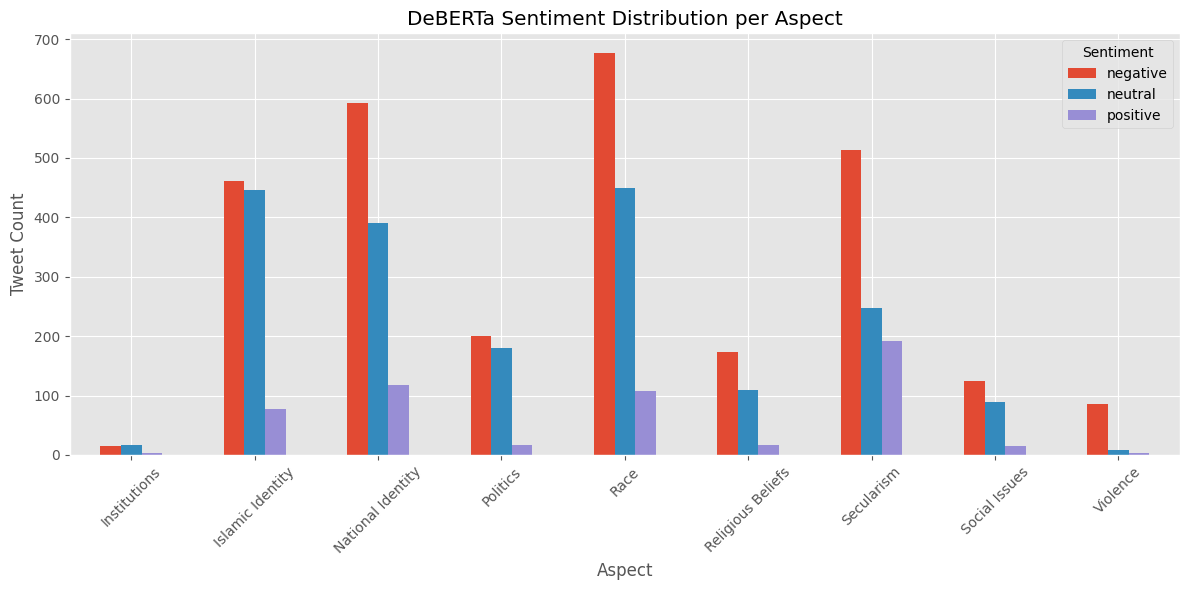

In [4]:
import matplotlib.pyplot as plt

# Count of DeBERTa sentiment per aspect
sentiment_dist = df.groupby(['aspect', 'deberta_sentiment']).size().unstack(fill_value=0)

# Plot (side-by-side/grouped bar chart)
sentiment_dist.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("DeBERTa Sentiment Distribution per Aspect")
plt.xlabel("Aspect")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


##Step 3: Plan for Fine-Tuning BERTweet

In [ ]:
!pip install transformers datasets scikit-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load DeBERTa-annotated data
df = pd.read_csv("ABSA-DeBERTa_annotate.csv")

# Combine aspect and text as input (common ABSA practice)
df['input_text'] = df['aspect'] + " [SEP] " + df['cleaned_text']

# Encode sentiment labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['deberta_sentiment'].map(label_map)

# Train-test split (80/20)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['input_text'], df['label'], test_size=0.2, random_state=42)


###Tokenize Using BERTweet

In [ ]:
from transformers import AutoTokenizer

# Load BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)

# Tokenize data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


###Create PyTorch Dataset

In [ ]:
import torch

class ABSA_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

# Create dataset
train_dataset = ABSA_Dataset(train_encodings, list(train_labels))
test_dataset = ABSA_Dataset(test_encodings, list(test_labels))


###Load BERTweet and Fine-Tune

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load BERTweet with classification head (3 sentiment classes)
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    # Changed evaluation_strategy to eval_strategy
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Train the Model

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import os # Import os module to set environment variable

# Load BERTweet with classification head (3 sentiment classes)
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=3)

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    # Changed evaluation_strategy to eval_strategy
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none" # Explicitly tell trainer not to report to any service
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Ensure wandb is disabled
os.environ["WANDB_DISABLED"] = "true"

# Train the model
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.771900,0.649298
2,0.568800,0.535190
3,0.333100,0.478490


TrainOutput(global_step=801, training_loss=0.609836171666037, metrics={'train_runtime': 14880.5964, 'train_samples_per_second': 0.859, 'train_steps_per_second': 0.054, 'total_flos': 650646078970734.0, 'train_loss': 0.609836171666037, 'epoch': 3.0})

###Predict and Save Results

In [ ]:
# Predict on test set
preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1).numpy()

# Save prediction results
test_df = pd.DataFrame({
    'input_text': test_texts,
    'true_label': test_labels,
    'predicted_label': pred_labels
})

# Map back to sentiment labels
inv_label_map = {v: k for k, v in label_map.items()}
test_df['true_sentiment'] = test_df['true_label'].map(inv_label_map)
test_df['predicted_sentiment'] = test_df['predicted_label'].map(inv_label_map)

test_df.to_csv("BERTweet_sentiment_predictions.csv", index=False)


In [8]:
import pandas as pd

# Load dataset
df = pd.read_csv("BERTweet_sentiment_predictions.csv")

# Extract aspect from input_text before [SEP]
df["aspect"] = df["input_text"].str.extract(r"^(.*?)\s+\[SEP\]")

# Group by aspect and true sentiment (DeBERTa)
true_dist = df.groupby(['aspect', 'true_sentiment']).size().unstack(fill_value=0)
true_dist.columns = [f"DeBERTa_{col}" for col in true_dist.columns]

# Group by aspect and predicted sentiment (BERTweet)
pred_dist = df.groupby(['aspect', 'predicted_sentiment']).size().unstack(fill_value=0)
pred_dist.columns = [f"BERTweet_{col}" for col in pred_dist.columns]

# Merge both distributions
comparison_df = pd.concat([true_dist, pred_dist], axis=1).fillna(0).astype(int)

# Save to CSV (optional)
comparison_df.to_csv("Sentiment_Comparison_DeBERTa_vs_BERTweet.csv")

# Display
print(comparison_df)


                   DeBERTa_negative  DeBERTa_neutral  DeBERTa_positive  \
aspect                                                                   
Institutions                      4                5                 0   
Islamic Identity                101               88                18   
National Identity                99               84                22   
Politics                         37               30                 2   
Race                            137               94                22   
Religious Beliefs                31               21                 1   
Secularism                      107               53                32   
Social Issues                    27               21                 3   
Violence                         23                4                 0   

                   BERTweet_negative  BERTweet_neutral  BERTweet_positive  
aspect                                                                     
Institutions                     

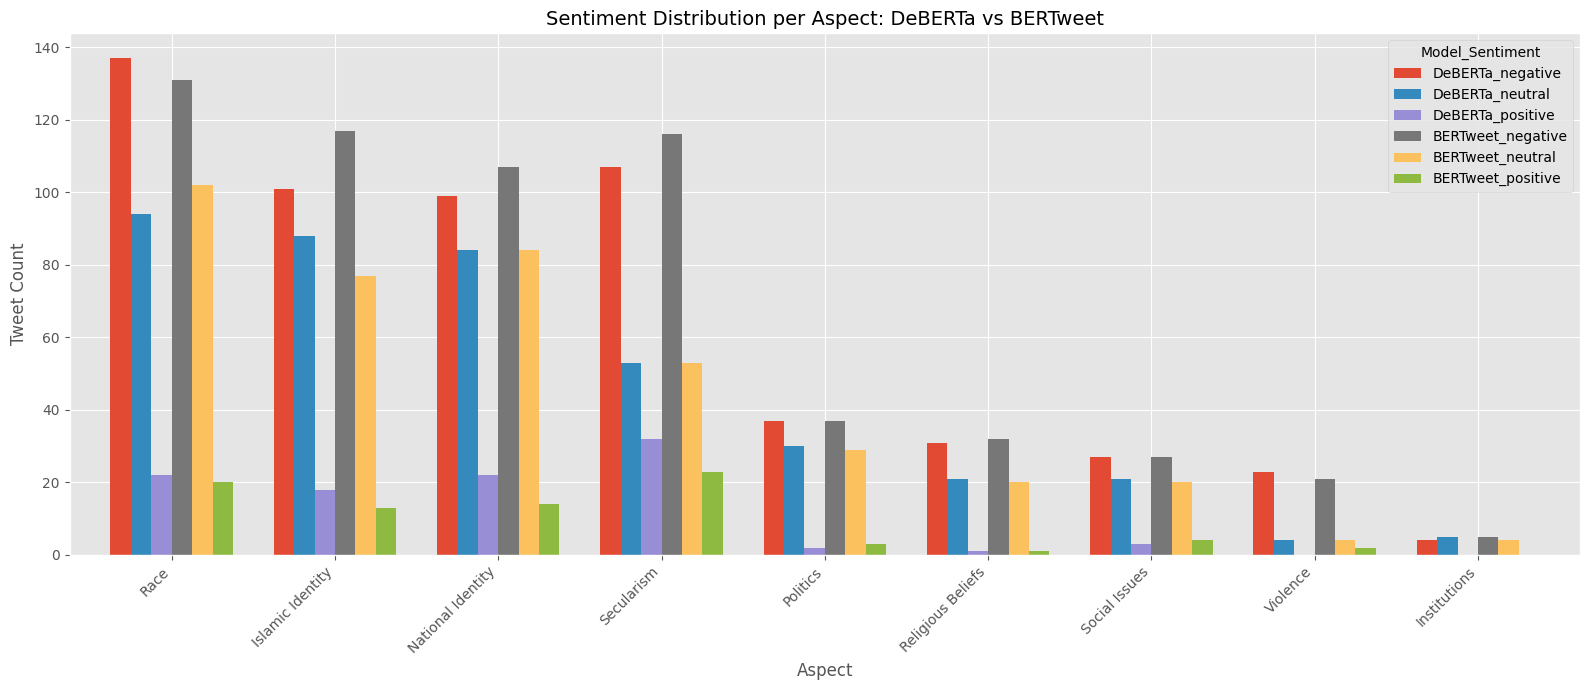

In [9]:
# Extract aspect from input_text before [SEP]
df["aspect"] = df["input_text"].str.extract(r"^(.*?)\s+\[SEP\]")

# Count sentiment distribution
true_dist = df.groupby(['aspect', 'true_sentiment']).size().unstack(fill_value=0)
true_dist.columns = [f"DeBERTa_{col}" for col in true_dist.columns]

pred_dist = df.groupby(['aspect', 'predicted_sentiment']).size().unstack(fill_value=0)
pred_dist.columns = [f"BERTweet_{col}" for col in pred_dist.columns]

# Combine
comparison_df = pd.concat([true_dist, pred_dist], axis=1).fillna(0).astype(int)

# Optional: sort by total tweets per aspect
comparison_df = comparison_df.loc[comparison_df.sum(axis=1).sort_values(ascending=False).index]

# Plot
ax = comparison_df.plot(kind='bar', figsize=(16, 7), width=0.75)
plt.title("Sentiment Distribution per Aspect: DeBERTa vs BERTweet", fontsize=14)
plt.xlabel("Aspect", fontsize=12)
plt.ylabel("Tweet Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Model_Sentiment", fontsize=10)
plt.tight_layout()
plt.show()


##Step 4: Evaluation of BERTweet vs DeBERTa

file contains these columns:
 - true_sentiment – from DeBERTa
 - predicted_sentiment – from BERTweet

In [10]:
import pandas as pd

# Load prediction results
df = pd.read_csv("BERTweet_sentiment_predictions.csv")

# Check available columns
print(df.columns)
df.head()


Index(['input_text', 'true_label', 'predicted_label', 'true_sentiment',
       'predicted_sentiment'],
      dtype='object')


,input_text,true_label,predicted_label,true_sentiment,predicted_sentiment
0,Islamic Identity [SEP] always remember malaysi...,0,0,negative,negative
1,Race [SEP] muslim league which led the movemen...,1,1,neutral,neutral
2,Race [SEP] similar to islam where saudis promo...,1,1,neutral,neutral
3,Secularism [SEP] malaysia is not a secular cou...,0,1,negative,neutral
4,Religious Beliefs [SEP] abolish all nonsk scho...,0,1,negative,neutral


###Encode Sentiment Labels

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels
le = LabelEncoder()
df['true_encoded'] = le.fit_transform(df['true_sentiment'])
df['pred_encoded'] = le.transform(df['predicted_sentiment'])

# Map
print("Label Encoding Map:", dict(zip(le.classes_, le.transform(le.classes_))))


Label Encoding Map: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


###ACCURACY

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['true_encoded'], df['pred_encoded'])
print(f"Ketepatan (Accuracy): {accuracy:.4f}")


Ketepatan (Accuracy): 0.8443


###PRECISION

In [16]:
from sklearn.metrics import precision_score

precision = precision_score(df['true_encoded'], df['pred_encoded'], average='weighted')
print(f"Kepersisan (Precision - Weighted): {precision:.4f}")


Kepersisan (Precision - Weighted): 0.8417


###RECALL

In [17]:
from sklearn.metrics import recall_score

recall = recall_score(df['true_encoded'], df['pred_encoded'], average='weighted')
print(f"Kepekaan (Recall - Weighted): {recall:.4f}")


Kepekaan (Recall - Weighted): 0.8443


###F1-SCORE

In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(df['true_encoded'], df['pred_encoded'], average='weighted')
print(f"Skor-F1 (Weighted): {f1:.4f}")


Skor-F1 (Weighted): 0.8419


In [20]:
print("METRIK PENILAIAN MODEL BERTWEET:")
print(f"Ketepatan (Accuracy)      : {accuracy:.4f}")
print(f"Kepersisan (Precision)    : {precision:.4f}")
print(f"Kepekaan (Recall)         : {recall:.4f}")
print(f"Skor-F1 (F1-score)        : {f1:.4f}")


METRIK PENILAIAN MODEL BERTWEET:
Ketepatan (Accuracy)      : 0.8443
Kepersisan (Precision)    : 0.8417
Kepekaan (Recall)         : 0.8443
Skor-F1 (F1-score)        : 0.8419


###Confusion Matrix

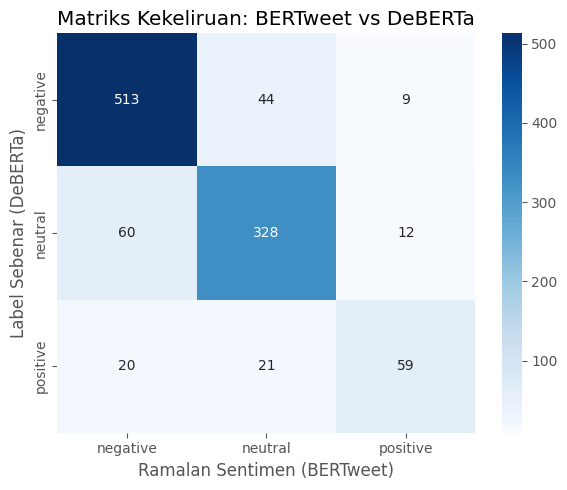

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Jana confusion matrix
cm = confusion_matrix(df['true_encoded'], df['pred_encoded'])

# Visualkan sebagai heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Ramalan Sentimen (BERTweet)")
plt.ylabel("Label Sebenar (DeBERTa)")
plt.title("Matriks Kekeliruan: BERTweet vs DeBERTa")
plt.tight_layout()
plt.show()


The model demonstrates its best performance on the negative class, with 513 out of 566 correctly classified instances (approximately 90.6% accuracy).

The neutral class also shows reasonably good performance, with 328 out of 400 instances correctly predicted (82% accuracy).

However, the positive class recorded the lowest performance, with only 59 out of 100 correctly classified (59% accuracy), while the remaining instances were mostly misclassified as either neutral or negative